In [80]:
import seaborn as sns

import pandas as pd
import numpy as np

from statsmodels.formula import api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.special import softmax

In [75]:
def datagen(N=1000):
    
    TOTAL_PANEL = 52
    CHOICES = [0, 1, 2]
    P = [0.75, 0.2, 0.05]

    full_panel_data = np.random.choice(a = CHOICES, size = (N, TOTAL_PANEL), p = P)
    unit_total = full_panel_data.sum(axis=1)

    N_SURROGATES = 4
    surrogate_data = full_panel_data[:, :N_SURROGATES]


    data = (
        pd.DataFrame(
            data = np.hstack([surrogate_data, unit_total.reshape(-1, 1)]), 
            columns=[f"surrogate_{i}" for i in range(N_SURROGATES)] + ['unit_total']
        )
    )
    return data

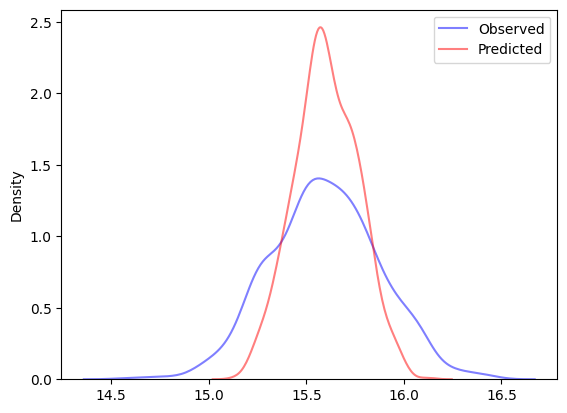

In [88]:
def return_statistic(data, use_point_estimate=True, eval_metrics:list[callable]=None):
    train_data, test_data = train_test_split(data, test_size = 0.2)
    model = smf.ols('unit_total ~ ' + ' + '.join(data.columns[:-1]), data = train_data).fit()
    

    test_observed_mean = test_data['unit_total'].mean()
    test_predicted_mean = model.predict(test_data).mean()
    
    return_package = []

    if use_point_estimate:
        return_package.append(test_observed_mean)
        return_package.append(test_predicted_mean)
    else:
        test_prediction_std = model.predict(test_data).std()
        test_rnd_mean = np.random.normal(test_predicted_mean, test_prediction_std, size = 1)[0]
        return_package.append(test_observed_mean)
        return_package.append(test_rnd_mean)

    if eval_metrics is not None:
        eval_metric_values = [
            eval_metric(test_data['unit_total'], model.predict(test_data)) for eval_metric in eval_metrics
        ]
        return_package.append(eval_metric_values)

    
    return return_package

observed_values = []
predicted_values = []
metric_values = []
for i in range(1000):
    data = datagen()
    observed, predicted, metrics = return_statistic(data, eval_metrics = [mean_squared_error, mean_absolute_error, lambda x, y: mean_absolute_error(x, y)/x.mean()])
    observed_values.append(observed)
    predicted_values.append(predicted)
    metric_values.append(metrics)

bins = np.arange(10, 20)

ax= sns.kdeplot(observed_values, color = 'blue', alpha = 0.5, label = 'Observed',)
sns.kdeplot(predicted_values, color = 'red', alpha = 0.5, label = 'Predicted', ax = ax, )
ax.legend()
        
    

In [89]:
metric_values = np.array(metric_values)

<Axes: ylabel='Density'>

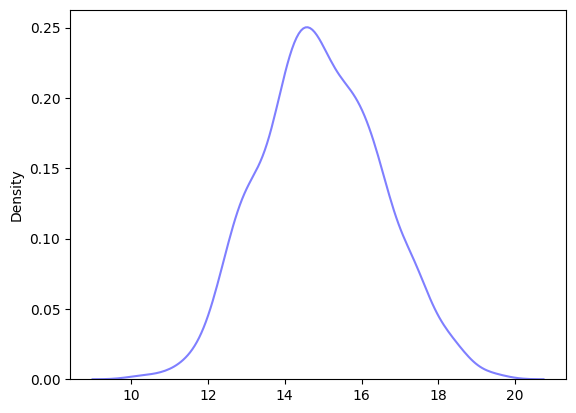

In [90]:
sns.kdeplot(metric_values[:, 0], color = 'blue', alpha = 0.5, label = 'MSE')

<Axes: ylabel='Density'>

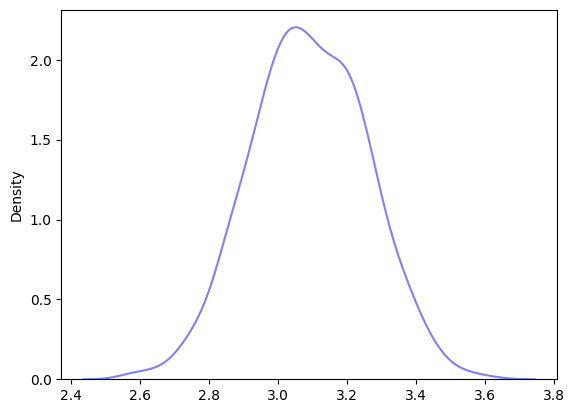

In [91]:
sns.kdeplot(metric_values[:, 1], color = 'blue', alpha = 0.5, label = 'MAE')

<Axes: ylabel='Density'>

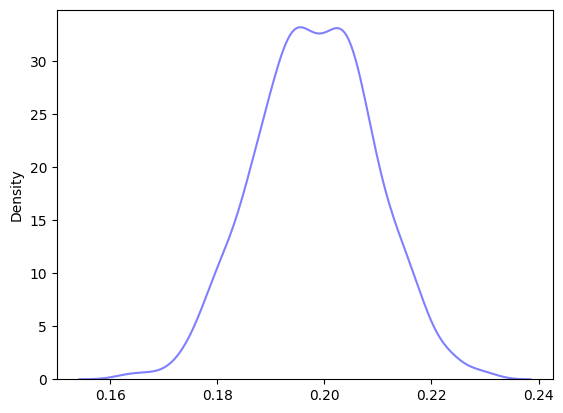

In [92]:
sns.kdeplot(metric_values[:, 2], color = 'blue', alpha = 0.5, label = 'MAE/mean')

# Adding user-level parameter: $p_i$

In [ ]:
def datagen(N = 10000):
    TOTAL_PANEL = 52
    
    CHOICES = [0, 1, 2]
    UNIT_P = np.random.randint(0, 10, size=N).reshape(-1, 1)
    P = softmax(np.hstack([UNIT_P, UNIT_P / 4, UNIT_P / 8]), axis=1)

    full_panel_data = np.vstack([np.random.choice(a = CHOICES, size = (1, TOTAL_PANEL), p = P[x]) for x in range(N)])

    data = (
        pd.DataFrame(
            data = full_panel_data,
            columns=[f"surrogate_{i}" for i in range(TOTAL_PANEL)] 
        )
        .assign(
            unit_total = lambda df: df.sum(axis=1)
        )
    )
    return data

<Axes: xlabel='value', ylabel='Density'>

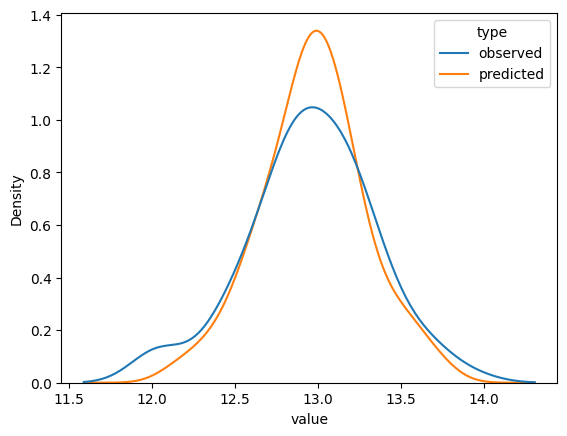

In [58]:
def return_statistic(data, n_surrogates:int=4):
    train_data, test_data = train_test_split(data, test_size = 0.2)
    surrogate_columns = [f"surrogate_{i}" for i in range(n_surrogates)]
    model = smf.ols('unit_total ~ ' + ' + '.join(surrogate_columns), data = train_data).fit()
    test_observed_mean = test_data['unit_total'].mean()
    test_predicted_mean = model.predict(test_data).mean()
    return test_observed_mean, test_predicted_mean

observed_values = []
predicted_values = []
for i in range(100):
    data = datagen()
    observed, predicted = return_statistic(data)
    observed_values.append(observed)
    predicted_values.append(predicted)

bins = np.arange(10, 20)

plot_data = (
    pd.DataFrame(
        data = {
            'observed': observed_values,
            'predicted': predicted_values
        }
    )
    .melt(
        value_vars = ['observed', 'predicted'],
        value_name = 'value',
        var_name = 'type'
    )
)

sns.kdeplot(
    data = plot_data,
    x = 'value',
    hue = 'type',
    common_norm = False,
    common_grid = True
)